## X-Ray Abnormality Detection | CNN

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
- [Baseline Performance](#Baseline-Performance)
 * [Random Classification, all study types](#Random-Classification,-all-study-types)
 * [CNN architecture with sensible defaults, all study types](#CNN-architecture-with-sensible-defaults,-all-study-types)
 * [Only on XR_SHOULDER study type](#Only-on-XR_SHOULDER-study-type)
 * [Only on XR_ELBOW study type](#Only-on-XR_ELBOW-study-type)
 * [Only on XR_HUMERUS study type](#Only-on-XR_HUMERUS-study-type)
 * [Only on XR_HAND study type](#Only-on-XR_HAND-study-type)
 * [Only on XR_WRIST study type](#Only-on-XR_WRIST-study-type)
 * [Only on XR_FOREARM study type](#Only-on-XR_FOREARM-study-type)
 * [Only on XR_FINGER study type](#Only-on-XR_FINGER-study-type)


In [1]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

from utils import (
    clean_up,
    F1Score,
    inspect_df,
    plot_metrics,
)

pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-04-02 09:56:31.169680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 09:56:31.175639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 09:56:31.175819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [8]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [9]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [10]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [11]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [12]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [13]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [14]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [15]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [16]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

Since image directory follows a specific ontological structure (7 upper extremities aka study types) we will shuffle the training dataset beforehand in order to ensure that the validation set will be representable of all study types. 

This is due to the fact that tf.keras `tf.keras.preprocessing.image.ImageDataGenerator` first performs the train-val split and then shuffles per epoch by default.

In [17]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [18]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    rescale=1.0 / 255,
    validation_split=0.25,
)

In [19]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 27606 validated image filenames belonging to 2 classes.


In [20]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 9202 validated image filenames belonging to 2 classes.


### Baseline Performance

We will try to establish, through some very basic architectures (from naive random classification to a simple CNN) the complexity of the problem.

This is very important, as it will serve as a reference on our efforts to find a better-suited architecture for the problem.

#### Random Classification, all study types

In [21]:
class RandomClassifier(object):
    """Random classifier - predicts whether an image is normal or abnormal at random."""

    def predict(self) -> float:

        return random.random()

In [22]:
model = RandomClassifier()


labels = validationset.labels
preds = [model.predict() for _ in labels]

In [23]:
cohen_kappa_score(
    labels,
    np.vectorize(lambda x: 1 if x > 0.5 else 0)(preds),
)

0.003174287007781662

#### CNN architecture with sensible defaults, all study types

In [24]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-04-02 09:56:32.571828: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-02 09:56:32.572776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 09:56:32.572978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 09:56:32.573095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [25]:
def make_cnn_model():
    """Creates a CNN architecture with sensible defaults."""
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                name="1st-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="1st-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="1st-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="1st-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="2nd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="2nd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="2nd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="2nd-dropout",
            ),
            tf.keras.layers.Conv2D(
                filters=128,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding="same",
                kernel_regularizer="l2",
                dilation_rate=(1, 1),
                activation="relu",
                name="3rd-convolution",
            ),
            tf.keras.layers.BatchNormalization(name="3rd-batch-norm"),
            tf.keras.layers.MaxPool2D(
                pool_size=(2, 2), strides=(2, 2), padding="same", name="3rd-max-pooling"
            ),
            tf.keras.layers.Dropout(
                rate=0.15,
                name="3rd-dropout",
            ),
            tf.keras.layers.Flatten(name="flatten-layer"),
            tf.keras.layers.Dense(
                units=32,
                kernel_regularizer="l2",
                activation="relu",
                name="dense-layer",
            ),
            tf.keras.layers.Dense(units=1, activation="sigmoid", name="output-layer"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [26]:
model = make_cnn_model()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st-convolution (Conv2D)    (None, 224, 224, 32)      896       
                                                                 
 1st-batch-norm (BatchNormal  (None, 224, 224, 32)     128       
 ization)                                                        
                                                                 
 1st-max-pooling (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 1st-dropout (Dropout)       (None, 112, 112, 32)      0         
                                                                 
 2nd-convolution (Conv2D)    (None, 112, 112, 64)      18496     
                                                                 
 2nd-batch-norm (BatchNormal  (None, 112, 112, 64)     2

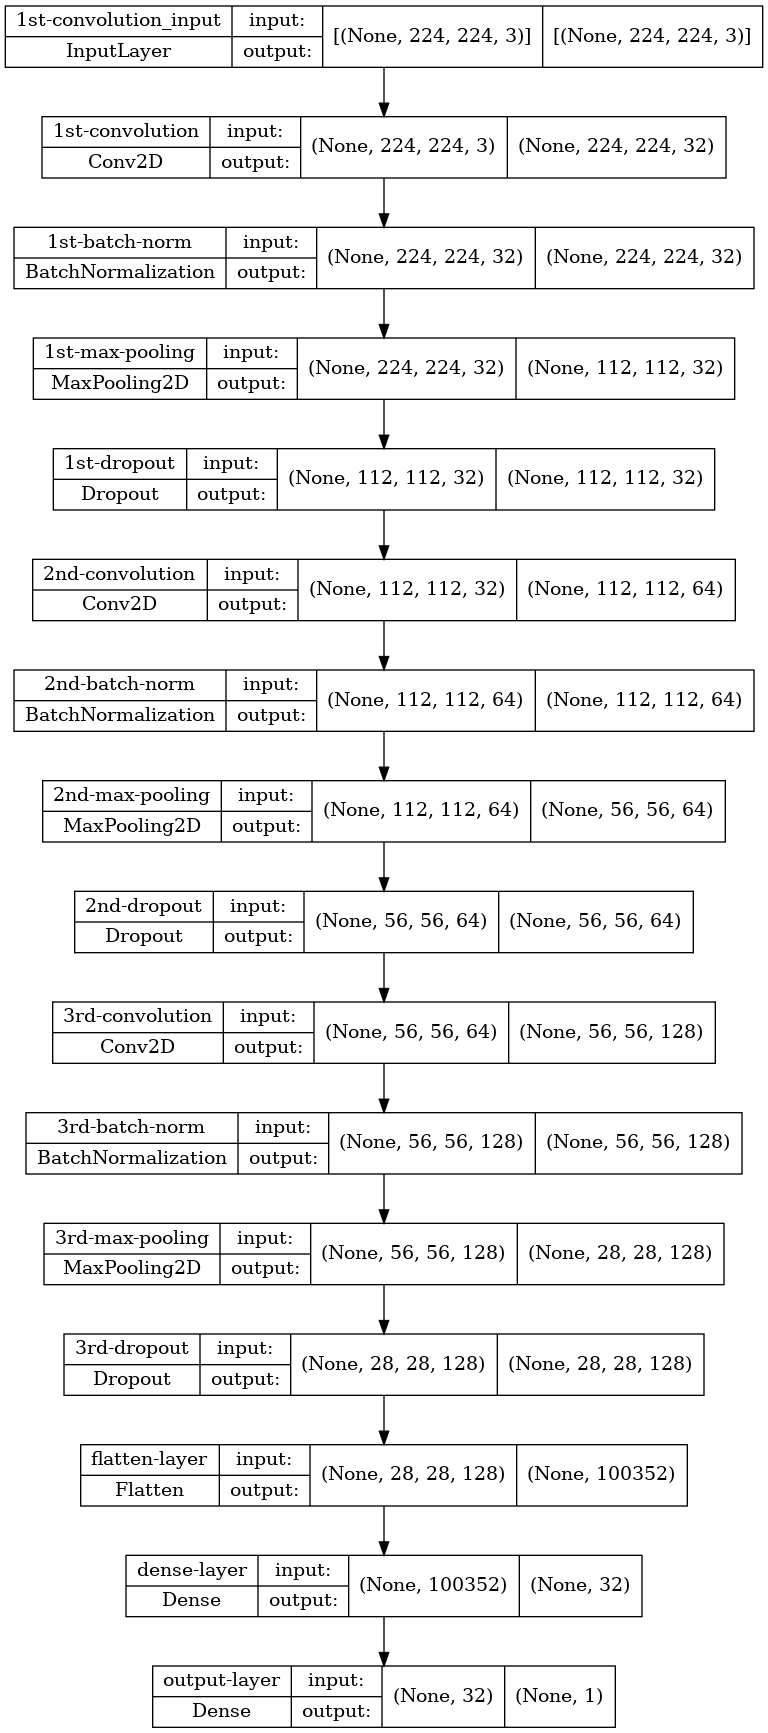

In [28]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/cnn-all-study-types-3305473.png",
    show_shapes=True,
    show_layer_names=True,
)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
)

In [30]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa", factor=0.2, verbose=1, patience=7, min_lr=1e-10
)

In [31]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100


2022-04-02 09:56:36.324825: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


863/863 [==============================] - 309s 353ms/step - loss: 1.9433 - tp: 165.0000 - fp: 188.0000 - tn: 16270.0000 - fn: 10983.0000 - binary_acc: 0.5953 - precision: 0.4674 - recall: 0.0148 - f1_score: 0.0287 - roc_auc: 0.5609 - pr_auc: 0.4391 - cohen_kappa: 0.0040 - val_loss: 1.7985 - val_tp: 1173.0000 - val_fp: 2143.0000 - val_tn: 3334.0000 - val_fn: 2552.0000 - val_binary_acc: 0.4898 - val_precision: 0.3537 - val_recall: 0.3149 - val_f1_score: 0.3332 - val_roc_auc: 0.4720 - val_pr_auc: 0.3748 - val_cohen_kappa: -0.0777 - lr: 1.0000e-04
Epoch 2/100
863/863 [==============================] - 300s 348ms/step - loss: 1.1020 - tp: 12.0000 - fp: 22.0000 - tn: 16436.0000 - fn: 11136.0000 - binary_acc: 0.5958 - precision: 0.3529 - recall: 0.0011 - f1_score: 0.0021 - roc_auc: 0.5773 - pr_auc: 0.4496 - cohen_kappa: -3.1006e-04 - val_loss: 1.1012 - val_tp: 576.0000 - val_fp: 1099.0000 - val_tn: 4378.0000 - val_fn: 3149.0000 - val_binary_acc: 0.5384 - val_precision: 0.3439 - val_recall: 0

Epoch 15/100
863/863 [==============================] - ETA: 0s - loss: 0.5959 - tp: 5791.0000 - fp: 2283.0000 - tn: 14175.0000 - fn: 5357.0000 - binary_acc: 0.7232 - precision: 0.7172 - recall: 0.5195 - f1_score: 0.6025 - roc_auc: 0.7778 - pr_auc: 0.7246 - cohen_kappa: 0.3985
Epoch 15: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
863/863 [==============================] - 302s 350ms/step - loss: 0.5959 - tp: 5791.0000 - fp: 2283.0000 - tn: 14175.0000 - fn: 5357.0000 - binary_acc: 0.7232 - precision: 0.7172 - recall: 0.5195 - f1_score: 0.6025 - roc_auc: 0.7778 - pr_auc: 0.7246 - cohen_kappa: 0.3985 - val_loss: 0.6995 - val_tp: 1107.0000 - val_fp: 370.0000 - val_tn: 5107.0000 - val_fn: 2618.0000 - val_binary_acc: 0.6753 - val_precision: 0.7495 - val_recall: 0.2972 - val_f1_score: 0.4256 - val_roc_auc: 0.7187 - val_pr_auc: 0.6601 - val_cohen_kappa: 0.2542 - lr: 2.0000e-05
Epoch 16/100
863/863 [==============================] - 312s 362ms/step - loss: 0.5849 - tp: 59

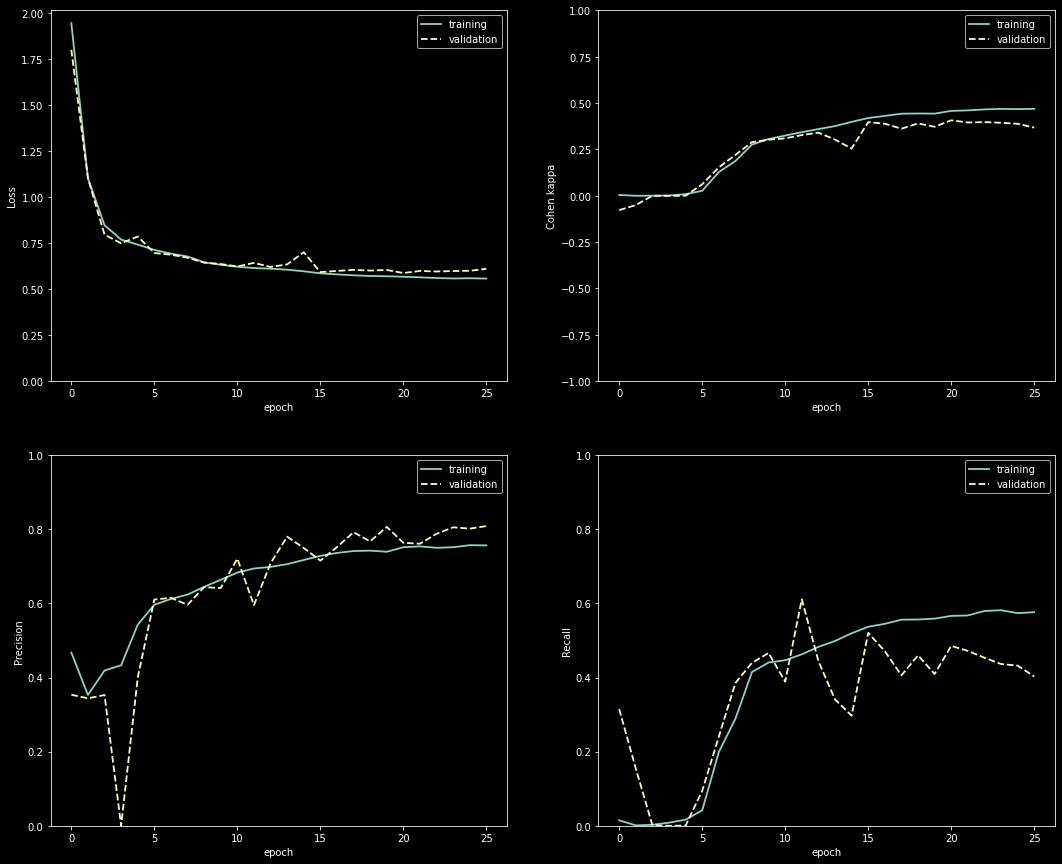

In [32]:
plot_metrics(history)

In [33]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

288/288 [==============================] - 74s 257ms/step - loss: 0.6059 - tp: 1512.0000 - fp: 338.0000 - tn: 5139.0000 - fn: 2213.0000 - binary_acc: 0.7228 - precision: 0.8173 - recall: 0.4059 - f1_score: 0.5424 - roc_auc: 0.7903 - pr_auc: 0.7447 - cohen_kappa: 0.3743


In [34]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.6059115529060364
tp          : 1512.0
fp          : 338.0
tn          : 5139.0
fn          : 2213.0
binary_acc  : 0.7227776646614075
precision   : 0.8172972798347473
recall      : 0.4059060513973236
f1_score    : 0.5424215793609619
roc_auc     : 0.7903357148170471
pr_auc      : 0.744694173336029
cohen_kappa : 0.3743298053741455


In [35]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-all-study-types-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-all-study-types-3305473.h5")

In [36]:
clean_up(model)

#### Only on XR_SHOULDER study type

In [37]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 6285 validated image filenames belonging to 2 classes.


In [38]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_SHOULDER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 2094 validated image filenames belonging to 2 classes.


In [39]:
model = make_cnn_model()

In [40]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
197/197 [==============================] - 73s 364ms/step - loss: 2.5255 - tp: 4244.0000 - fp: 3090.0000 - tn: 5534.0000 - fn: 2619.0000 - binary_acc: 0.6314 - precision: 0.5787 - recall: 0.6184 - f1_score: 0.5979 - roc_auc: 0.7056 - pr_auc: 0.6490 - cohen_kappa: 0.2583 - val_loss: 8.4971 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1064.0000 - val_fn: 1030.0000 - val_binary_acc: 0.5081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4919 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 75s 378ms/step - loss: 2.0927 - tp: 3135.0000 - fp: 3147.0000 - tn: 0.0000e+00 - fn: 3.0000 - binary_acc: 0.4988 - precision: 0.4990 - recall: 0.9990 - f1_score: 0.6656 - roc_auc: 0.4997 - pr_auc: 0.4991 - cohen_kappa: -9.5463e-04 - val_loss: 5.9033 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 1060.0000 - val_fn: 1028.0000 - val_binary_acc: 0.5072 - val_precision: 

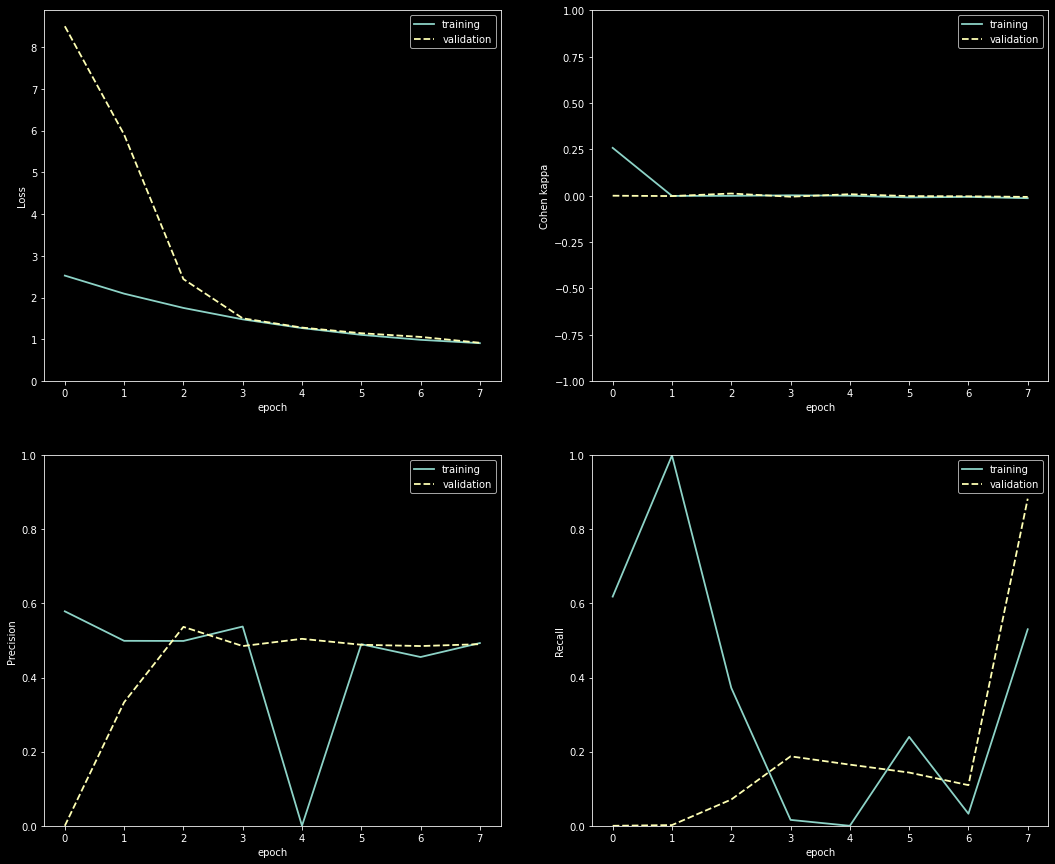

In [41]:
plot_metrics(history)

In [42]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

66/66 [==============================] - 17s 258ms/step - loss: 0.9225 - tp: 894.0000 - fp: 944.0000 - tn: 120.0000 - fn: 136.0000 - binary_acc: 0.4842 - precision: 0.4864 - recall: 0.8680 - f1_score: 0.6234 - roc_auc: 0.5052 - pr_auc: 0.4930 - cohen_kappa: -0.0190


In [43]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.9224685430526733
tp          : 894.0
fp          : 944.0
tn          : 120.0
fn          : 136.0
binary_acc  : 0.48424068093299866
precision   : 0.48639824986457825
recall      : 0.8679611682891846
f1_score    : 0.6234309673309326
roc_auc     : 0.5052221417427063
pr_auc      : 0.4930022358894348
cohen_kappa : -0.01901841163635254


In [44]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_SHOULDER-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_SHOULDER-3305473.h5")

In [45]:
clean_up(model)

#### Only on XR_ELBOW study type

In [46]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 3699 validated image filenames belonging to 2 classes.


In [47]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_ELBOW"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 1232 validated image filenames belonging to 2 classes.


In [48]:
model = make_cnn_model()

In [49]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
116/116 [==============================] - 43s 360ms/step - loss: 2.6809 - tp: 1257.0000 - fp: 1362.0000 - tn: 1888.0000 - fn: 1286.0000 - binary_acc: 0.5429 - precision: 0.4800 - recall: 0.4943 - f1_score: 0.4870 - roc_auc: 0.5622 - pr_auc: 0.4738 - cohen_kappa: 0.0750 - val_loss: 5.8123 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 739.0000 - val_fn: 493.0000 - val_binary_acc: 0.5998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5000 - val_pr_auc: 0.4002 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
116/116 [==============================] - 42s 359ms/step - loss: 2.3564 - tp: 495.0000 - fp: 446.0000 - tn: 1740.0000 - fn: 1018.0000 - binary_acc: 0.6042 - precision: 0.5260 - recall: 0.3272 - f1_score: 0.4034 - roc_auc: 0.6272 - pr_auc: 0.5020 - cohen_kappa: 0.1307 - val_loss: 6.2586 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 739.0000 - val_fn: 493.0000 - val_binary_acc: 0.5998 - val_precision: 0

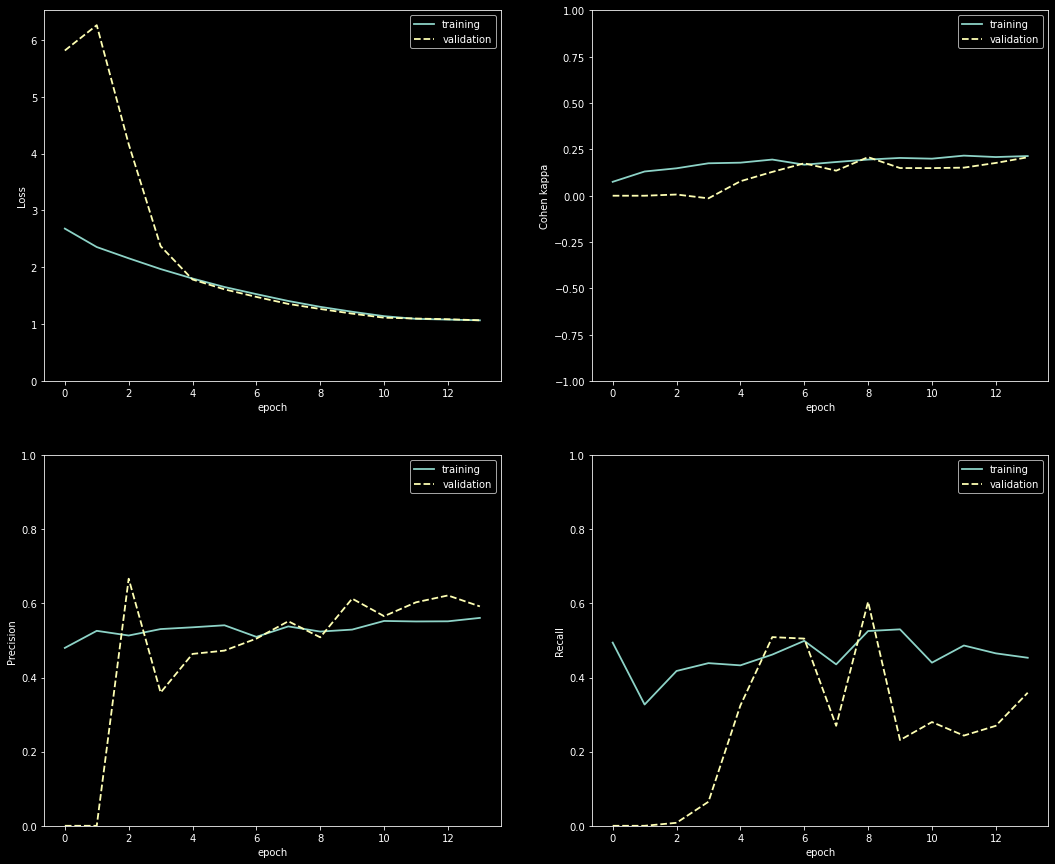

In [50]:
plot_metrics(history)

In [51]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

39/39 [==============================] - 10s 254ms/step - loss: 1.0706 - tp: 171.0000 - fp: 124.0000 - tn: 615.0000 - fn: 322.0000 - binary_acc: 0.6380 - precision: 0.5797 - recall: 0.3469 - f1_score: 0.4340 - roc_auc: 0.6589 - pr_auc: 0.5182 - cohen_kappa: 0.1919


In [52]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 1.0706390142440796
tp          : 171.0
fp          : 124.0
tn          : 615.0
fn          : 322.0
binary_acc  : 0.6379870176315308
precision   : 0.5796610116958618
recall      : 0.3468559980392456
f1_score    : 0.4340101480484009
roc_auc     : 0.6588655710220337
pr_auc      : 0.5181971788406372
cohen_kappa : 0.1918887495994568


In [53]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_ELBOW-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_ELBOW-3305473.h5")

In [54]:
clean_up(model)

#### Only on XR_HUMERUS study type

In [55]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 954 validated image filenames belonging to 2 classes.


In [56]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HUMERUS"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 318 validated image filenames belonging to 2 classes.


In [57]:
model = make_cnn_model()

In [58]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
30/30 [==============================] - 14s 432ms/step - loss: 2.7804 - tp: 451.0000 - fp: 427.0000 - tn: 817.0000 - fn: 491.0000 - binary_acc: 0.5801 - precision: 0.5137 - recall: 0.4788 - f1_score: 0.4956 - roc_auc: 0.6014 - pr_auc: 0.4967 - cohen_kappa: 0.1366 - val_loss: 3.2309 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 168.0000 - val_fn: 150.0000 - val_binary_acc: 0.5283 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5413 - val_pr_auc: 0.4833 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 11s 367ms/step - loss: 2.5597 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 505.0000 - fn: 449.0000 - binary_acc: 0.5294 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.5808 - pr_auc: 0.5210 - cohen_kappa: 0.0000e+00 - val_loss: 4.2640 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 168.0000 - val_fn: 150.0000 - val_binary_acc: 0.5283 - val_pr

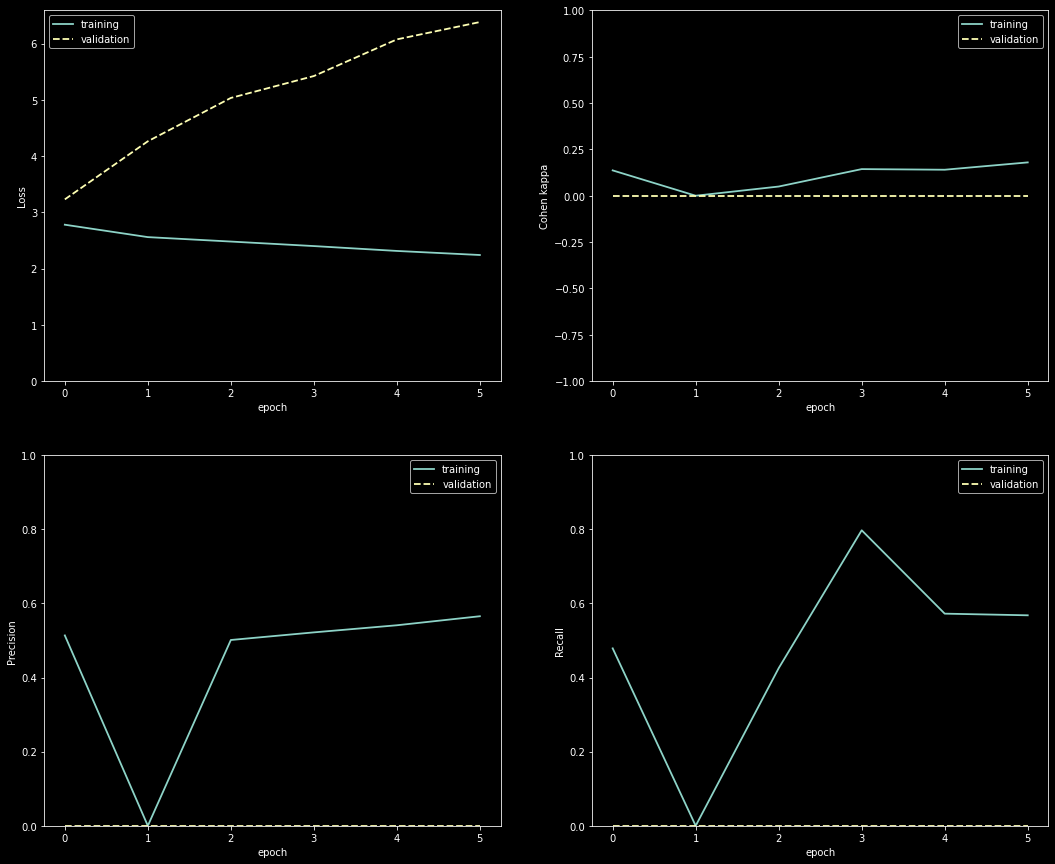

In [59]:
plot_metrics(history)

In [60]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

10/10 [==============================] - 3s 277ms/step - loss: 6.3801 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168.0000 - fn: 150.0000 - binary_acc: 0.5283 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.5000 - pr_auc: 0.4717 - cohen_kappa: 0.0000e+00


In [61]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 6.380105495452881
tp          : 0.0
fp          : 0.0
tn          : 168.0
fn          : 150.0
binary_acc  : 0.5283018946647644
precision   : 0.0
recall      : 0.0
f1_score    : 0.0
roc_auc     : 0.5
pr_auc      : 0.4716981053352356
cohen_kappa : 0.0


In [62]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HUMERUS-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_HUMERUS-3305473.h5")

In [63]:
clean_up(model)

#### Only on XR_HAND study type

In [64]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 4158 validated image filenames belonging to 2 classes.


In [65]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_HAND"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 1385 validated image filenames belonging to 2 classes.


In [66]:
model = make_cnn_model()

In [67]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
130/130 [==============================] - 53s 395ms/step - loss: 2.4997 - tp: 21.0000 - fp: 70.0000 - tn: 3165.0000 - fn: 1220.0000 - binary_acc: 0.7118 - precision: 0.2308 - recall: 0.0169 - f1_score: 0.0315 - roc_auc: 0.4852 - pr_auc: 0.2666 - cohen_kappa: -0.0066 - val_loss: 15.1625 - val_tp: 393.0000 - val_fp: 992.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.2838 - val_precision: 0.2838 - val_recall: 1.0000 - val_f1_score: 0.4421 - val_roc_auc: 0.5000 - val_pr_auc: 0.2838 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
130/130 [==============================] - 48s 365ms/step - loss: 2.1112 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3067.0000 - fn: 1091.0000 - binary_acc: 0.7376 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.5934 - pr_auc: 0.3322 - cohen_kappa: 0.0000e+00 - val_loss: 14.3911 - val_tp: 393.0000 - val_fp: 992.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_binary_acc: 0.2838 - val_preci

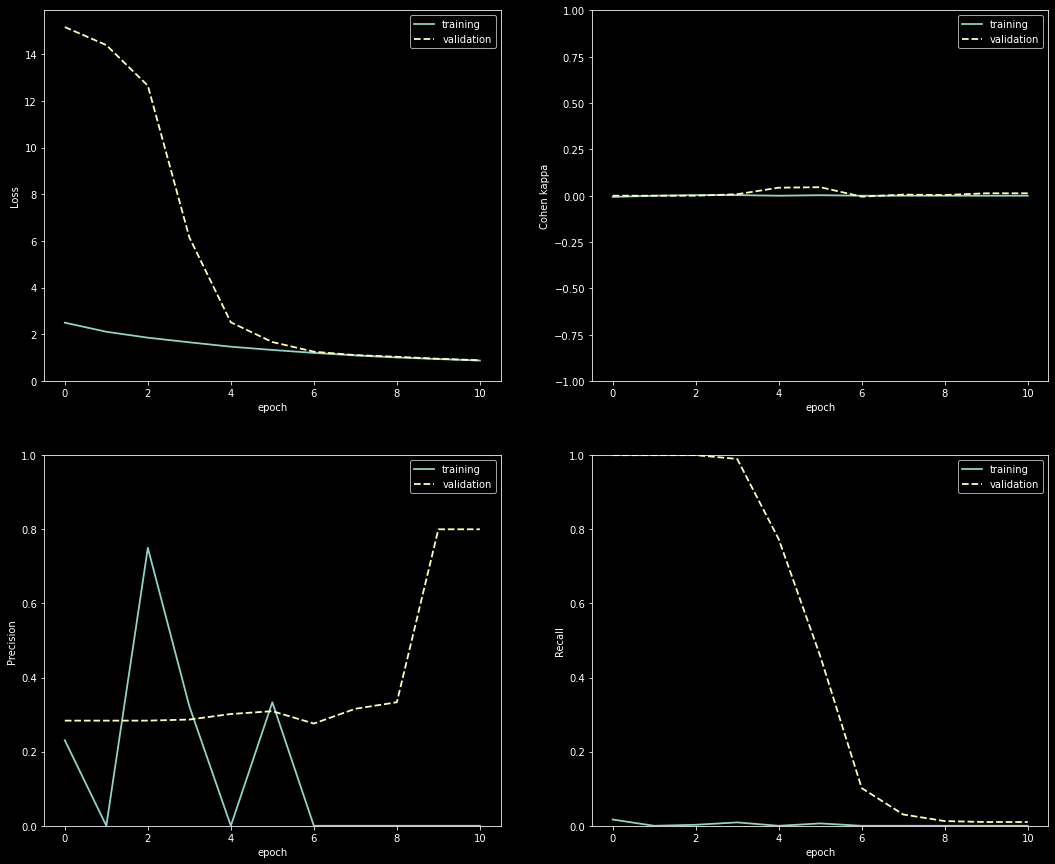

In [68]:
plot_metrics(history)

In [69]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

44/44 [==============================] - 12s 271ms/step - loss: 0.8927 - tp: 2.0000 - fp: 1.0000 - tn: 991.0000 - fn: 391.0000 - binary_acc: 0.7170 - precision: 0.6667 - recall: 0.0051 - f1_score: 0.0101 - roc_auc: 0.6055 - pr_auc: 0.3893 - cohen_kappa: 0.0058


In [70]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.8926740288734436
tp          : 2.0
fp          : 1.0
tn          : 991.0
fn          : 391.0
binary_acc  : 0.7169675230979919
precision   : 0.6666666865348816
recall      : 0.005089058540761471
f1_score    : 0.010101010091602802
roc_auc     : 0.6054787039756775
pr_auc      : 0.389335572719574
cohen_kappa : 0.005826771259307861


In [71]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_HAND-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_HAND-3305473.h5")

In [72]:
clean_up(model)

#### Only on XR_WRIST study type

In [73]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 7314 validated image filenames belonging to 2 classes.


In [74]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_WRIST"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 2438 validated image filenames belonging to 2 classes.


In [75]:
model = make_cnn_model()

In [76]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
229/229 [==============================] - 87s 372ms/step - loss: 2.5178 - tp: 110.0000 - fp: 139.0000 - tn: 5157.0000 - fn: 3293.0000 - binary_acc: 0.6055 - precision: 0.4418 - recall: 0.0323 - f1_score: 0.0602 - roc_auc: 0.5769 - pr_auc: 0.4377 - cohen_kappa: 0.0073 - val_loss: 3.1037 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1461.0000 - val_fn: 977.0000 - val_binary_acc: 0.5993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5918 - val_pr_auc: 0.4710 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
229/229 [==============================] - 83s 363ms/step - loss: 2.0857 - tp: 63.0000 - fp: 64.0000 - tn: 4240.0000 - fn: 2947.0000 - binary_acc: 0.5883 - precision: 0.4961 - recall: 0.0209 - f1_score: 0.0402 - roc_auc: 0.5613 - pr_auc: 0.4481 - cohen_kappa: 0.0071 - val_loss: 2.0306 - val_tp: 346.0000 - val_fp: 462.0000 - val_tn: 999.0000 - val_fn: 631.0000 - val_binary_acc: 0.5517 - val_precision: 0.4282 -

229/229 [==============================] - 82s 357ms/step - loss: 0.7212 - tp: 1805.0000 - fp: 751.0000 - tn: 3553.0000 - fn: 1205.0000 - binary_acc: 0.7326 - precision: 0.7062 - recall: 0.5997 - f1_score: 0.6486 - roc_auc: 0.8033 - pr_auc: 0.7637 - cohen_kappa: 0.4350 - val_loss: 0.7416 - val_tp: 515.0000 - val_fp: 218.0000 - val_tn: 1243.0000 - val_fn: 462.0000 - val_binary_acc: 0.7211 - val_precision: 0.7026 - val_recall: 0.5271 - val_f1_score: 0.6023 - val_roc_auc: 0.7794 - val_pr_auc: 0.7306 - val_cohen_kappa: 0.3942 - lr: 8.0000e-07
Epoch 29/100
229/229 [==============================] - ETA: 0s - loss: 0.7206 - tp: 1809.0000 - fp: 767.0000 - tn: 3537.0000 - fn: 1201.0000 - binary_acc: 0.7309 - precision: 0.7023 - recall: 0.6010 - f1_score: 0.6477 - roc_auc: 0.8040 - pr_auc: 0.7635 - cohen_kappa: 0.4322
Epoch 29: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
229/229 [==============================] - 83s 365ms/step - loss: 0.7206 - tp: 1809.0000 - fp: 767.000

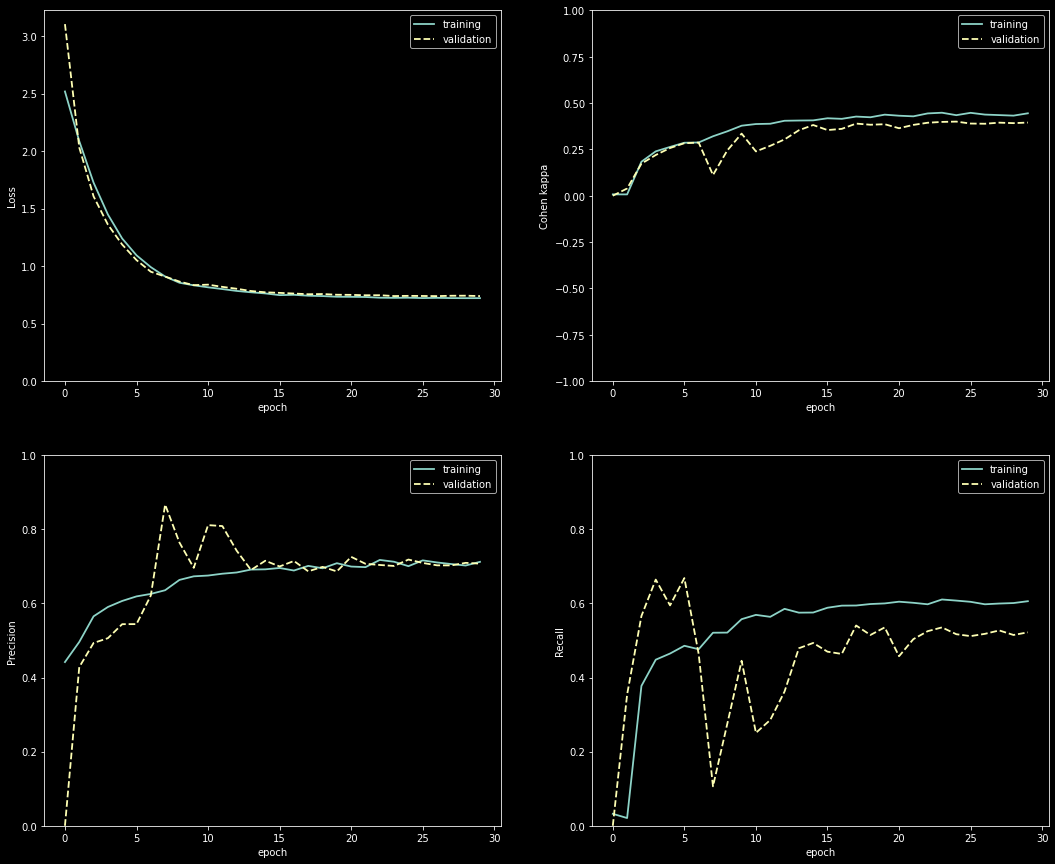

In [77]:
plot_metrics(history)

In [78]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

77/77 [==============================] - 21s 275ms/step - loss: 0.7393 - tp: 512.0000 - fp: 209.0000 - tn: 1252.0000 - fn: 465.0000 - binary_acc: 0.7235 - precision: 0.7101 - recall: 0.5241 - f1_score: 0.6031 - roc_auc: 0.7829 - pr_auc: 0.7364 - cohen_kappa: 0.3983


In [79]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.7393240332603455
tp          : 512.0
fp          : 209.0
tn          : 1252.0
fn          : 465.0
binary_acc  : 0.7235438823699951
precision   : 0.7101248502731323
recall      : 0.5240532159805298
f1_score    : 0.6030624508857727
roc_auc     : 0.7829381227493286
pr_auc      : 0.7364398241043091
cohen_kappa : 0.39828699827194214


In [80]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_WRIST-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_WRIST-3305473.h5")

In [81]:
clean_up(model)

#### Only on XR_FOREARM study type

In [82]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 1369 validated image filenames belonging to 2 classes.


In [83]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FOREARM"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 456 validated image filenames belonging to 2 classes.


In [84]:
model = make_cnn_model()

In [85]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
43/43 [==============================] - 23s 504ms/step - loss: 2.7949 - tp: 642.0000 - fp: 375.0000 - tn: 1949.0000 - fn: 841.0000 - binary_acc: 0.6806 - precision: 0.6313 - recall: 0.4329 - f1_score: 0.5136 - roc_auc: 0.7025 - pr_auc: 0.6159 - cohen_kappa: 0.2879 - val_loss: 3.0344 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 301.0000 - val_fn: 155.0000 - val_binary_acc: 0.6601 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_roc_auc: 0.5442 - val_pr_auc: 0.3535 - val_cohen_kappa: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
43/43 [==============================] - 17s 392ms/step - loss: 2.5532 - tp: 138.0000 - fp: 131.0000 - tn: 732.0000 - fn: 368.0000 - binary_acc: 0.6355 - precision: 0.5130 - recall: 0.2727 - f1_score: 0.3561 - roc_auc: 0.5992 - pr_auc: 0.4783 - cohen_kappa: 0.1339 - val_loss: 3.6394 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 301.0000 - val_fn: 155.0000 - val_binary_acc: 0.6601 - val_precision: 0.0000e+00

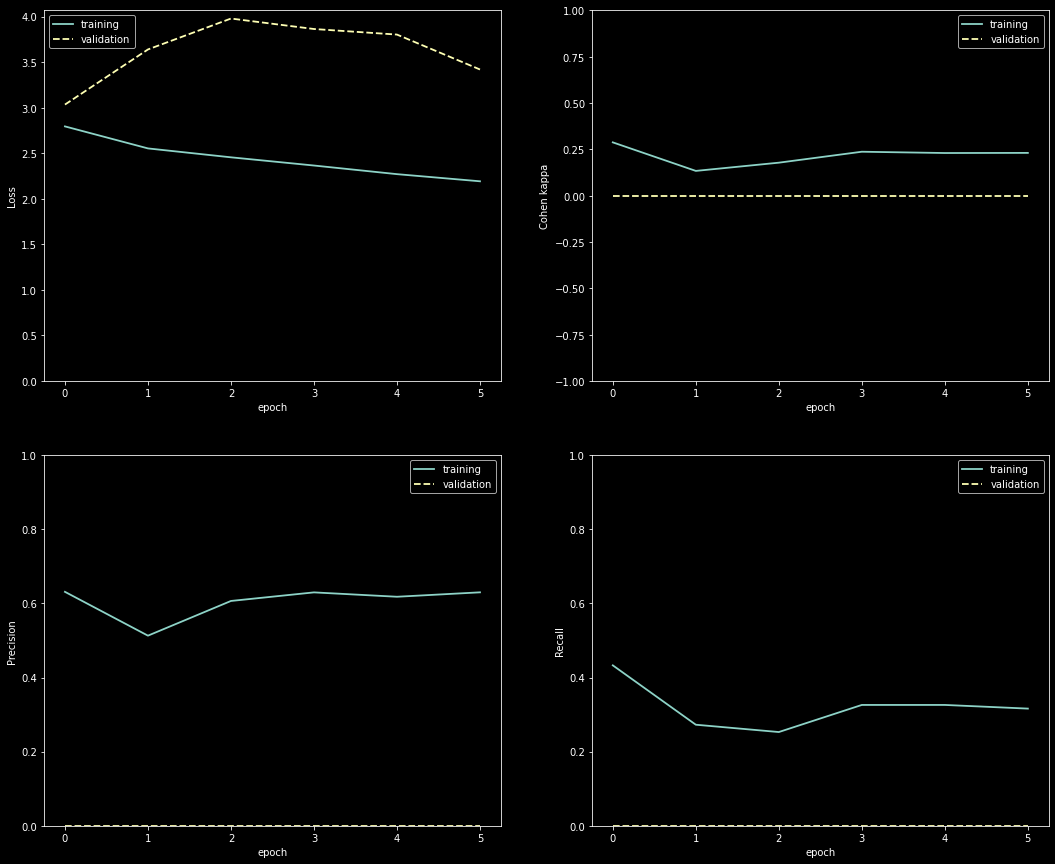

In [86]:
plot_metrics(history)

In [87]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

15/15 [==============================] - 4s 266ms/step - loss: 3.4426 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 301.0000 - fn: 155.0000 - binary_acc: 0.6601 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - roc_auc: 0.4895 - pr_auc: 0.3218 - cohen_kappa: 0.0000e+00


In [88]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 3.4426259994506836
tp          : 0.0
fp          : 0.0
tn          : 301.0
fn          : 155.0
binary_acc  : 0.6600877046585083
precision   : 0.0
recall      : 0.0
f1_score    : 0.0
roc_auc     : 0.4895402491092682
pr_auc      : 0.3218265771865845
cohen_kappa : 0.0


In [89]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FOREARM-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_FOREARM-3305473.h5")

In [90]:
clean_up(model)

#### Only on XR_FINGER study type

In [91]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 3830 validated image filenames belonging to 2 classes.


In [92]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset[ref_trainset["study_type"] == "XR_FINGER"],
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 1276 validated image filenames belonging to 2 classes.


In [93]:
model = make_cnn_model()

In [94]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/100
120/120 [==============================] - 49s 390ms/step - loss: 2.5506 - tp: 621.0000 - fp: 569.0000 - tn: 2110.0000 - fn: 986.0000 - binary_acc: 0.6372 - precision: 0.5218 - recall: 0.3864 - f1_score: 0.4440 - roc_auc: 0.6398 - pr_auc: 0.4896 - cohen_kappa: 0.1836 - val_loss: 2.4856 - val_tp: 268.0000 - val_fp: 419.0000 - val_tn: 341.0000 - val_fn: 248.0000 - val_binary_acc: 0.4773 - val_precision: 0.3901 - val_recall: 0.5194 - val_f1_score: 0.4456 - val_roc_auc: 0.4649 - val_pr_auc: 0.3707 - val_cohen_kappa: -0.0303 - lr: 1.0000e-04
Epoch 2/100
120/120 [==============================] - 44s 364ms/step - loss: 2.2659 - tp: 624.0000 - fp: 576.0000 - tn: 1802.0000 - fn: 828.0000 - binary_acc: 0.6334 - precision: 0.5200 - recall: 0.4298 - f1_score: 0.4706 - roc_auc: 0.6839 - pr_auc: 0.5285 - cohen_kappa: 0.1941 - val_loss: 2.5501 - val_tp: 507.0000 - val_fp: 751.0000 - val_tn: 9.0000 - val_fn: 9.0000 - val_binary_acc: 0.4044 - val_precision: 0.4030 - val_recall: 0.9826 - va

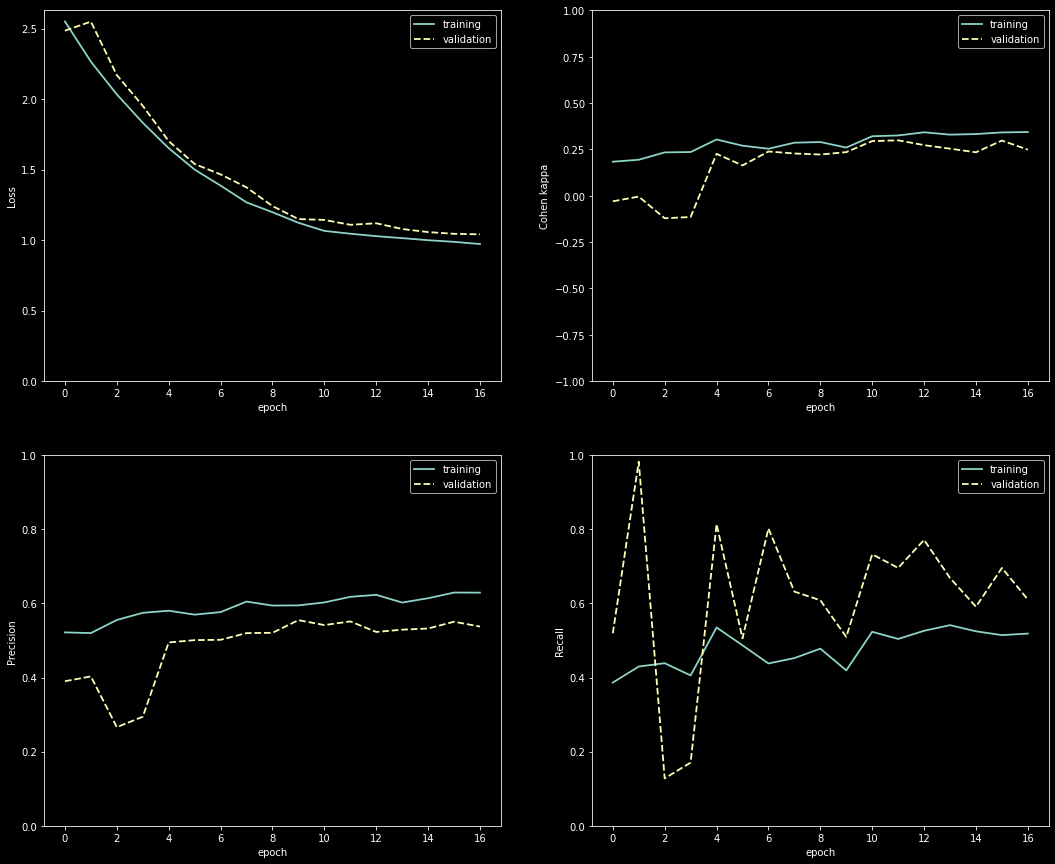

In [95]:
plot_metrics(history)

In [96]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

40/40 [==============================] - 10s 255ms/step - loss: 1.0353 - tp: 323.0000 - fp: 280.0000 - tn: 480.0000 - fn: 193.0000 - binary_acc: 0.6293 - precision: 0.5357 - recall: 0.6260 - f1_score: 0.5773 - roc_auc: 0.7000 - pr_auc: 0.5875 - cohen_kappa: 0.2508


In [97]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 1.0353106260299683
tp          : 323.0
fp          : 280.0
tn          : 480.0
fn          : 193.0
binary_acc  : 0.6293103694915771
precision   : 0.5356550812721252
recall      : 0.6259689927101135
f1_score    : 0.5773012042045593
roc_auc     : 0.6999579071998596
pr_auc      : 0.5874971747398376
cohen_kappa : 0.25076091289520264


In [98]:
# model naming convention: {architecture}-{study-type}-{num-parameters}.h5
#
# to load model:
# model = tf.keras.models.load_model(
#     '../models/cnn-XR_FINGER-3305473.h5',
#     custom_objects={'F1Score': F1Score}
# )
model.save("../models/cnn-XR_FINGER-3305473.h5")

In [99]:
clean_up(model)